# ALE plots - intervals effect

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook we will explore how the choice of interval affects the ALE distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Load data

In [2]:
# Load the California House price data from Scikit-learn

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns=["Latitude", "Longitude"])

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


In [3]:
# split data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50)

## Random Forest

In [4]:
# train model

rf = RandomForestRegressor(
    n_estimators=30,
    max_depth=3,
    random_state=3,
).fit(X_train, y_train)

In [5]:
# R2 in train set

rf.score(X_train, y_train)

0.5662519439438518

In [6]:
# R2 in test set

rf.score(X_test, y_test)

0.5455953740118167

The model explains > 50% of the variability in the target.

## ALE plot

In [7]:
def plot_ale(model, X, feature, n_bins, quantiles=True):

    if quantiles is True:
        feat_cut, bins = pd.qcut(
            X[feature],
            q=n_bins,
            retbins=True,
        )

    else:
        feat_cut, bins = pd.cut(
            X[feature],
            bins=n_bins,
            include_lowest=True,
            retbins=True,
        )

    # the bin into which the observation is allocated
    bin_number = feat_cut.cat.codes

    # make a copy
    X1 = X.copy()
    X2 = X.copy()

    # replace with the lowest value in one df
    # and the highest value in the next:

    X1[feature] = [bins[i] for i in bin_number]
    X2[feature] = [bins[i + 1] for i in bin_number]

    # obtain predictions
    y_1 = model.predict(X1).ravel()
    y_2 = model.predict(X2).ravel()

    # obtain difference between predictions
    delta_df = pd.DataFrame({
        "bin": bins[bin_number + 1],
        "delta": y_2 - y_1,
    })

    # obtain mean difference in prediction per interval
    res_df = delta_df.groupby(["bin"])["delta"].agg(
        [("effect", "mean"), "size"])

    # aggregate the differences
    res_df["ale"] = res_df["effect"].cumsum()

    # add the value for the first bin
    res_df.loc[min(bins), :] = 0

    # center
    mean_mv_avg = (
        (res_df["effect"] + res_df["effect"].shift(1, fill_value=0)) /
        2 * res_df["size"]
    ).sum() / res_df["size"].sum()

    res_df = res_df.sort_index().assign(
        ale_centered=res_df["ale"] - mean_mv_avg)

    # prepare for plotting
    res_df.reset_index(inplace=True)

    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    res_df["size"].plot.bar(ax=ax)
    res_df["ale_centered"].plot(ax=ax2, color="r")

    plt.title(f"ALE plot - {feature} - bins={n_bins} - quantiles={quantiles}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Effect on prediction")
    plt.xticks(res_df.index, np.round(res_df["bin"], 2))
    plt.show()

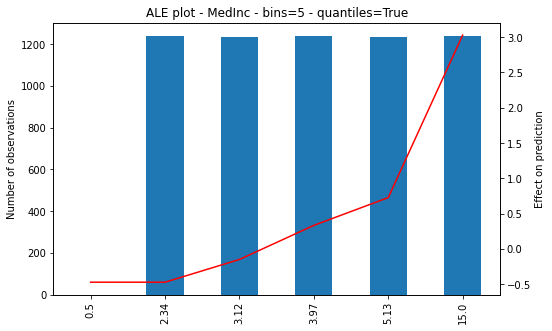

In [8]:
plot_ale(rf, X_test, "MedInc", 5, quantiles=True)

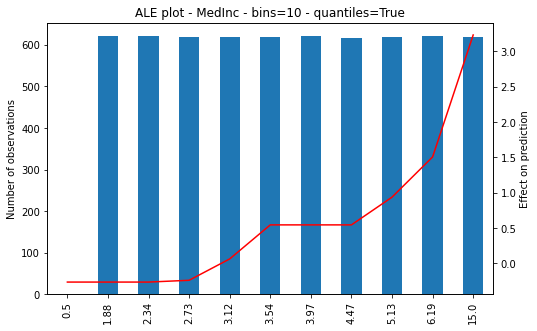

In [9]:
plot_ale(rf, X_test, "MedInc", 10, quantiles=True)

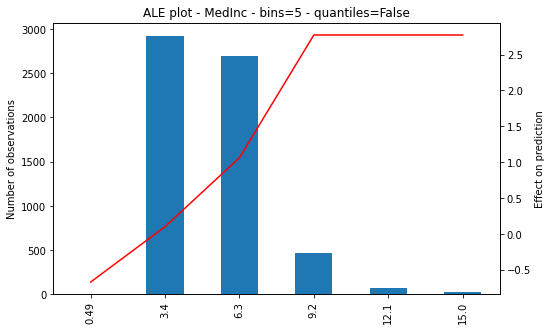

In [10]:
plot_ale(rf, X_test, "MedInc", 5, quantiles=False)

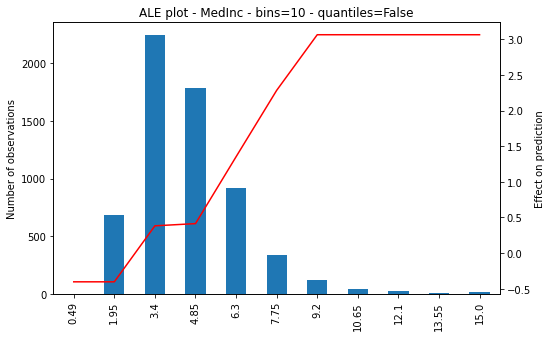

In [11]:
plot_ale(rf, X_test, "MedInc", 10, quantiles=False)